In [1]:
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dir = "/content/drive/Shareddrives/ECS260-group5/dataset/npm/"
dep_fname = dir + "(NPM_extracted)dependencies-1.6.0-2020-01-12.csv"
proj_fname = dir + "(NPM_extracted)projects-1.6.0-2020-01-12.csv"
projRep_fname = dir + "(NPM_extracted)projects_with_repository_fields-1.6.0-2020-01-12.csv"

samples = 3

dep_hd = pd.read_csv(dep_fname, nrows=samples)
display(dep_hd)

,ID,Platform,Project Name,Project ID,Version Number,Version ID,Dependency Name,Dependency Platform,Dependency Kind,Optional Dependency,Dependency Requirements,Dependency Project ID
0,1080746,NPM,7,30621,0.0.1,18347,should,NPM,Development,False,~1.2.2,313128
1,1080747,NPM,7,30621,0.0.1,18347,mocha,NPM,Development,False,~1.12.0,295363
2,1080748,NPM,7,30621,0.0.2,18348,should,NPM,Development,False,~1.2.2,313128


In [ ]:
with open(dep_fname, "r") as csvfile:
  datareader = csv.reader(csvfile)
  header = next(datareader)
  print('Header index')
  for i, attr in enumerate(header):   
    print(i, attr)

Header index
0 ID
1 Platform
2 Project Name
3 Project ID
4 Version Number
5 Version ID
6 Dependency Name
7 Dependency Platform
8 Dependency Kind
9 Optional Dependency
10 Dependency Requirements
11 Dependency Project ID


In [ ]:
with open(projRep_fname, "r") as csvfile:
  datareader = csv.reader(csvfile)
  header = next(datareader)
  print('Header index')
  for i, attr in enumerate(header):   
    print(i, attr)

Header index
0 ID
1 Platform
2 Name
3 Created Timestamp
4 Updated Timestamp
5 Description
6 Keywords
7 Homepage URL
8 Licenses
9 Repository URL
10 Versions Count
11 SourceRank
12 Latest Release Publish Timestamp
13 Latest Release Number
14 Package Manager ID
15 Dependent Projects Count
16 Language
17 Status
18 Last synced Timestamp
19 Dependent Repositories Count
20 Repository ID
21 Repository Host Type
22 Repository Name with Owner
23 Repository Description
24 Repository Fork?
25 Repository Created Timestamp
26 Repository Updated Timestamp
27 Repository Last pushed Timestamp
28 Repository Homepage URL
29 Repository Size
30 Repository Stars Count
31 Repository Language
32 Repository Issues enabled?
33 Repository Wiki enabled?
34 Repository Pages enabled?
35 Repository Forks Count
36 Repository Mirror URL
37 Repository Open Issues Count
38 Repository Default branch
39 Repository Watchers Count
40 Repository UUID
41 Repository Fork Source Name with Owner
42 Repository License
43 Reposito

In [ ]:
# Check dependency platform
# Some are non-npm

with open(dep_fname, "r") as csvfile:
  datareader = csv.reader(csvfile)
  next(datareader)  # yield the header row
  for row in datareader:
    dep_plat = row[7]
    if dep_plat != 'NPM': print(row)

['67130504', 'NPM', 'react-notification-alert', '2532623', '1.0.0', '11364178', 'MongoDB.Driver', 'NuGet', 'runtime', 'false', '>= 2.4.4', '611422']
['67130558', 'NPM', 'react-notification-alert', '2532623', '1.0.0', '11364178', 'MongoDB.Bson', 'NuGet', 'runtime', 'false', '>= 2.4.4', '1016545']
['67130482', 'NPM', 'react-notification-alert', '2532623', '1.0.0', '11364178', 'EntityFramework', 'NuGet', 'runtime', 'false', '>= 6.1.3', '631089']


In [3]:
# Build dictionary that maps ID to package name
name_dic = {}

with open(projRep_fname, "r") as csvfile:
  datareader = csv.reader(csvfile)
  next(datareader)  # yield the header row
  for row in datareader:
    id = row[0]
    name = row[2]
    name_dic[id] = name

In [ ]:
# check type of dependencies
kind = {}

with open(dep_fname, "r") as csvfile:
  datareader = csv.reader(csvfile)
  #next(datareader) # remove header
  for row in datareader:
    dep_kind = row[-4]
    if dep_kind in kind:
      kind[dep_kind] += 1
    else:
      kind[dep_kind] = 1

print(kind)

{'Dependency Kind': 1, 'Development': 91571308, 'runtime': 63336731, 'Optional': 6735}


In [4]:
# Build a dependency graph of npm packages

G = nx.DiGraph() # An empty directed graph

with open(dep_fname, "r") as csvfile:
  datareader = csv.reader(csvfile)
  next(datareader) # remove header
  for row in datareader:
    dep_kind = row[8]
    dep_plat = row[7]

    # Consider 'runtime' and 'optional' dependencies
    # Exclude non-npm dependency
    isRuntime = dep_kind != 'Development'
    isNPM = dep_plat == 'NPM'
    if isRuntime and isNPM:
      id = row[3]
      dep_id = row[-1]
      G.add_edge(id, dep_id) # Edge between two nodes represents dependency

In [5]:
# Graph basic stat
print('# of packages associated with dependency:', G.number_of_nodes())
print('# of packages not associated with any dependency:', len(name_dic) - G.number_of_nodes())
print('# of dependencies in the dependency graph:', G.number_of_edges())

# of packages associated with dependency: 914990
# of packages not associated with any dependency: 362231
# of dependencies in the dependency graph: 4946618


In [ ]:
# Get the isolated nodes (not associated to any incoming/outgoing dependency)
nodes = list(G.nodes)
print('Total', len(nodes), 'nodes in the dependency graph')

with open(dir + 'node_list.txt', 'w') as f:
  for node in nodes:
      f.write(node + '\n')

Total 914990 nodes in the dependency graph


In [ ]:
pr = nx.pagerank(G, max_iter=1000)

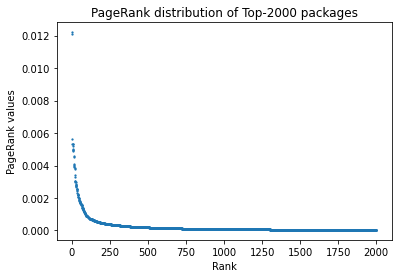

In [ ]:
sorted_pr = sorted(pr.items(), reverse=True, key = lambda d: d[1])
pr_vals = [val for (key, val) in sorted_pr]
plt.scatter(np.arange(1, 2001), pr_vals[:2000], s=1.5)
plt.xlabel('Rank')
plt.ylabel('PageRank values')
plt.title('PageRank distribution of Top-2000 packages')
plt.show()
plt.close('all')

In [ ]:
pr_keys = [key for (key, val) in sorted_pr]
top1000_pr = []

with open(dir + 'PageRank_npm.csv', 'w') as f:
  # set rank counter
  rank = 1
  load_failed = []

  # create the csv writer
  writer = csv.writer(f)

  # set header
  header = ['Rank', 'ID', 'Name', 'PageRank_value']
  writer.writerow(header)

  # write a row to the csv file
  for pkg_id in pr_keys:
    try: 
      #if rank > 1000: break
      pkg_name = name_dic[pkg_id]
      line = [str(rank), pkg_id, pkg_name, str(pr[pkg_id])]
      writer.writerow(line)
      print(line)
      rank += 1
      if rank < 1001: top1000_pr.append(pkg_name)
    except Exception as error:
      print(error)
      load_failed.append(pkg_id) # Error if there is no corresponding package name for pkg_id
      pass

Streaming output truncated to the last 5000 lines.
['909783', '4775393', '@sasho/flow-to-ts', '3.7722653942159206e-07']
['909784', '4775394', 'mat-page-block', '3.7722653942159206e-07']
['909785', '4775396', '@polymeshdev/ui', '3.7722653942159206e-07']
['909786', '4775401', 'iwc-create-app', '3.7722653942159206e-07']
['909787', '4775404', 'react-hubx', '3.7722653942159206e-07']
['909788', '4775408', 'wavefile-creator', '3.7722653942159206e-07']
['909789', '4775412', 'react-cart-test', '3.7722653942159206e-07']
['909790', '4775416', '@mothepro/lit-amazons', '3.7722653942159206e-07']
['909791', '4775418', 'queue-cli', '3.7722653942159206e-07']
['909792', '4775419', 'whatver', '3.7722653942159206e-07']
['909793', '4775420', '@rskaggs/codemash-2020-component-library', '3.7722653942159206e-07']
['909794', '4775421', '@negebauer/eslint-config-react', '3.7722653942159206e-07']
['909795', '4775424', 'global-user-tools', '3.7722653942159206e-07']
['909796', '4775425', 'verdaccio-example', '3.77

In [ ]:
# Number of packages that failed to match id to name
len(load_failed)

208

In [ ]:
test = pd.read_csv(dir + 'PageRank_npm.csv')
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914782 entries, 0 to 914781
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Rank            914782 non-null  int64  
 1   ID              914782 non-null  int64  
 2   Name            914780 non-null  object 
 3   PageRank_value  914782 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.9+ MB


,Rank,ID,Name,PageRank_value
0,1,167115,lodash,0.012205
1,2,1540922,tslib,0.012109
2,3,177932,object-assign,0.005654
3,4,134974,chalk,0.005333
4,5,649359,prop-types,0.005329


In [ ]:
G.clear()

In [ ]:
dep_dic = {}

# Count the number of dependency
with open(projRep_fname, "r") as csvfile:
  datareader = csv.reader(csvfile)
  next(datareader) # remove header
  for row in datareader:
    id = row[0]
    dep_cnt = int(row[15])

    dep_dic[id] = dep_cnt

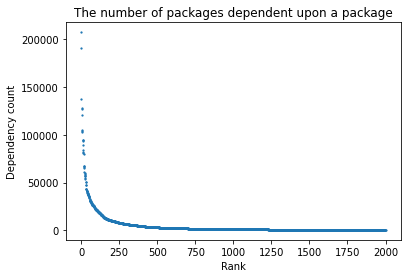

In [ ]:
sorted_counter = sorted(dep_dic.items(), reverse=True, key=lambda d: d[1])

count_vals = [val for (key, val) in sorted_counter]
plt.scatter(np.arange(1,2001), count_vals[:2000], s=1.5)
plt.xlabel('Rank')
plt.ylabel('Dependency count')
plt.title('The number of packages dependent upon a package')
plt.show()
plt.close('all')

In [ ]:
cnt_keys = [key for (key, val) in sorted_counter]

with open(dir + 'depCount_npm.csv', 'w') as f:
  # set rank counter
  rank = 1
  load_failed = []

  # create the csv writer
  writer = csv.writer(f)

  # set header
  header = ['Rank', 'ID', 'Name', 'Dependent Projects Count']
  writer.writerow(header)

  # write a row to the csv file
  for pkg_id in cnt_keys:
    try: 
      pkg_name = name_dic[pkg_id]
      line = [str(rank), pkg_id, pkg_name, str(dep_dic[pkg_id])]
      writer.writerow(line)
      print(line)
      rank += 1
    except Exception as error:
      print(error)
      load_failed.append(pkg_id) # Error if there is no corresponding package name for pkg_id
      pass

Streaming output truncated to the last 5000 lines.
['1272222', '4784585', 'kcv-theme-fresh', '0']
['1272223', '4784586', 'kcv-theme-eternal', '0']
['1272224', '4784587', 'kcv-theme-kendall-gren', '0']
['1272225', '4784588', 'kcv-theme-kendall', '0']
['1272226', '4784589', 'kcv-theme-paper', '0']
['1272227', '4784590', 'kcv-theme-orbit', '0']
['1272228', '4784591', 'kcv-theme-onepage-simplified', '0']
['1272229', '4784592', 'kcv-theme-moon', '0']
['1272230', '4784593', 'kcv-theme-onepage', '0']
['1272231', '4784594', 'kcv-theme-papirus-ru', '0']
['1272232', '4784595', 'kcv-theme-markdown', '0']
['1272233', '4784596', 'kcv-theme-mocha-responsive', '0']
['1272234', '4784597', 'kcv-theme-simple-red', '0']
['1272235', '4784598', 'kcv-theme-sshorter', '0']
['1272236', '4784599', 'kcv-theme-simple', '0']
['1272237', '4784600', 'kcv-theme-pumpkin', '0']
['1272238', '4784601', 'kcv-theme-riga', '0']
['1272239', '4784602', 'kcv-theme-retro', '0']
['1272240', '4784603', 'kcv-theme-responsive', '0

In [ ]:
# Number of packages that failed to match id to name
len(load_failed)

0

In [ ]:
test = pd.read_csv(dir + 'depCount_npm.csv')
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1277221 entries, 0 to 1277220
Data columns (total 4 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   Rank                      1277221 non-null  int64 
 1   ID                        1277221 non-null  int64 
 2   Name                      1277219 non-null  object
 3   Dependent Projects Count  1277221 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 39.0+ MB


,Rank,ID,Name,Dependent Projects Count
0,1,295363,mocha,207277
1,2,145391,eslint,190999
2,3,326120,typescript,137519
3,4,330445,webpack,128035
4,5,570149,babel-core,126919


In [ ]:
# Dependent Projects Count vs Dependent Repositories Count
proj = pd.read_csv(proj_fname)
subset = proj[["ID","Name","Dependent Projects Count", "Dependent Repositories Count"]]
large_drc = subset[subset["Dependent Repositories Count"] > (5 * subset["Dependent Projects Count"])]
large_drc = large_drc[large_drc["Dependent Repositories Count"] > 50]

large_drc.head(50)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,Name,Dependent Projects Count,Dependent Repositories Count
0,30617,0,6,429
10,30627,1,4,268
48,30665,2,16,176
167,126395,a-big-triangle,82,435
185,126413,a11y,17,86
187,126415,a127-magic,4,66
221,126449,abbrev,326,583185
257,126485,absolute,21,1086
259,126487,abs-svg-path,10,359
261,126489,absolute-path,113,25735


In [ ]:
with open(dir + 'test.csv', 'w') as f:
  # create the csv writer
  writer = csv.writer(f)

  header = list(large_drc.keys())
  header.append('degree')
  writer.writerow(header)
  print('Header:', header)

  iterator = large_drc.iterrows()

  for row in iterator:
    id = str(row[1]['ID'])
    name = row[1]['Name']
    dpc = row[1]['Dependent Projects Count']
    drc = row[1]['Dependent Repositories Count']
    try:
      deg = str(G.in_degree[id])
    except Exception as error:
      deg = 0
      pass
    line = [id, name, dpc, drc, deg]
    writer.writerow(line)

Header: ['ID', 'Name', 'Dependent Projects Count', 'Dependent Repositories Count', 'degree']


In [6]:
test = pd.read_csv(dir + 'test.csv')
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20763 entries, 0 to 20762
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ID                            20763 non-null  int64 
 1   Name                          20762 non-null  object
 2   Dependent Projects Count      20763 non-null  int64 
 3   Dependent Repositories Count  20763 non-null  int64 
 4   degree                        20763 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 811.2+ KB


,ID,Name,Dependent Projects Count,Dependent Repositories Count,degree
0,30617,0,6,429,5
1,30627,1,4,268,4
2,30665,2,16,176,16
3,126395,a-big-triangle,82,435,29
4,126413,a11y,17,86,12


In [7]:
iterator = test.iterrows()

dpcs = []
drcs = []
degs = []

for row in iterator:
    dpc = int(row[1]['Dependent Projects Count'])
    drc = int(row[1]['Dependent Repositories Count'])
    deg = int(row[1]['degree'])

    dpcs.append(dpc)
    drcs.append(drc)
    degs.append(deg)

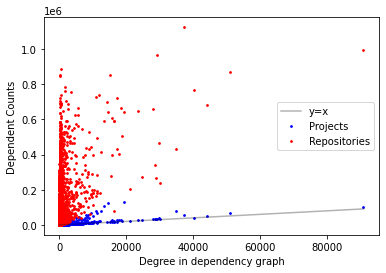

In [39]:
fig, ax = plt.subplots()
#ax.set_aspect('equal')

plt.ylabel('Dependent Counts')
plt.xlabel('Degree in dependency graph')

plt.scatter(degs, dpcs, c='b', s=3, label='Projects')
plt.scatter(degs, drcs, c='r', s=3, label='Repositories')

plt.plot(range(0,91000), range(0,91000), c='k', alpha=0.3, label='y=x')
plt.legend(loc='center right')
plt.show()
plt.close('all')